## Import the necesary  libraries

In [1]:
! git clone https://github.com/srobayo-gts/models.git

Cloning into 'models'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 4), reused 34 (delta 3), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [2]:
% cd models/capsnet_tf22

/content/models/capsnet_tf22


In [3]:
from tensorflow.keras import backend as K
import tensorflow
from tensorflow.keras import initializers, layers
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D, Layer, Reshape, Lambda, Softmax
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
import tensorflow as tf


import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
# import argparse
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.models import  Sequential, Model

# custom caps libraries
from CapsLayersKeras import CapsuleLayer, PrimaryCap, Length, Mask, margin_loss

# to confusion_matrix and roc courve 
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc 

K.set_image_data_format('channels_last')

In [4]:
tf.compat.v1.disable_eager_execution()

"""
https://github.com/tensorflow/tensorflow/issues/33747
with tf.device('CPU'):
    tensor2 = tf.identity(tensor1)

"""
print('Tensorflow Version: ', tf.__version__)

Tensorflow Version:  2.6.0


## Load images in binary npz format from repository

In [ ]:
train_data =  np.load('/content/drive/MyDrive/npzfiles/train.npz')
valid_data =  np.load('/content/drive/MyDrive/npzfiles/valid.npz')


## Load npz files

In [ ]:
x_train = None
y_train = None
x_valid = None
y_valid = None

x_train = train_data['x_train']
y_train = train_data['y_train']
x_valid = valid_data['x_valid']
y_valid = valid_data['y_valid']

In [ ]:
y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_valid, 2)

In [5]:
image_resize_height = 224 #224
image_resize_width  = 224 #224
channels = 3
input_shape=(image_resize_height,image_resize_height,channels)
number_of_classes = 2
batch_size = 32  # 60
EPOCHS = 50
np.prod(input_shape)

150528

## Define Layers

## Conv1 

In [6]:
x = Input(shape=input_shape)
OSmodel = Conv2D(32,kernel_size=(3,3), name="Conv1")(x)
OSmodel = Activation('relu')(OSmodel)
print(OSmodel.shape)
OSmodel = MaxPooling2D(pool_size=(2, 2), name="MaxPooling1")(OSmodel)
print(OSmodel.shape)


(None, 222, 222, 32)
(None, 111, 111, 32)


## Conv2

In [7]:
OSmodel = Conv2D(64,kernel_size=(3,3), name="Conv2")(OSmodel)
OSmodel = Activation('relu')(OSmodel)
print(OSmodel.shape)
OSmodel = MaxPooling2D(pool_size=(2, 2),  name="MaxPooling2")(OSmodel)
print(OSmodel.shape)
OSmodel.shape


(None, 109, 109, 64)
(None, 54, 54, 64)


TensorShape([None, 54, 54, 64])

Conv3

In [8]:
OSmodel = Conv2D(128,kernel_size=(3,3), name="Conv3")(OSmodel)
OSmodel = Activation('relu')(OSmodel)
print(OSmodel.shape)
OSmodel = MaxPooling2D(pool_size=(2, 2),  name="MaxPooling3")(OSmodel)
print(OSmodel.shape)
OSmodel.shape

(None, 52, 52, 128)
(None, 26, 26, 128)


TensorShape([None, 26, 26, 128])

Conv4

In [9]:
OSmodel = Conv2D(128,kernel_size=(3,3), name="Conv4")(OSmodel)
OSmodel = Activation('relu')(OSmodel)
print(OSmodel.shape)
OSmodel = MaxPooling2D(pool_size=(2, 2),  name="MaxPooling4")(OSmodel)
print(OSmodel.shape)
OSmodel.shape

(None, 24, 24, 128)
(None, 12, 12, 128)


TensorShape([None, 12, 12, 128])

## Conv5

In [10]:
conv1 = Conv2D(128, (3, 3),  name="Conv5")(OSmodel)
conv1 = Activation('relu')(conv1)
conv1.shape

TensorShape([None, 10, 10, 128])

## PrimaryCaps

In [11]:
# The second layer is a Primary Capsule layer resulting from 128×7×7 convolutions with strides of 1.
primaryCaps = PrimaryCap(inputs=conv1, dim_capsule=8, n_channels=16, kernel_size=3, strides=1, padding='valid')
primaryCaps.shape

TensorShape([None, 1024, 8])

## CapsuleLayer

In [12]:
# Final capsule layer includes 2 capsules, referred to as “Class Capsules,’ ’one for each of 2 classes. The dimension of these capsules is 16.

capLayer2 = CapsuleLayer(num_capsule=2, dim_capsule=16, routings=8, name="DigitCaps")(primaryCaps)
capLayer2.shape

TensorShape([None, 2, 16])

In [13]:
# Layer 4: This is an auxiliary layer to replace each capsule with its
# length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(capLayer2)
out_caps.shape

TensorShape([None, 2])

In [14]:
# Decoder network.
y = Input(shape=(number_of_classes,))
# The true label is used to mask the output of capsule layer. For training
masked_by_y = Mask()([capLayer2, y])
# Mask using the capsule with maximal length. For prediction
masked = Mask()(capLayer2)
masked.shape

TensorShape([None, None])

In [15]:
# Shared Decoder model in training and prediction
decoder = Sequential(name='decoder')
decoder.add(Dense(128,input_dim=16 * number_of_classes))
decoder.add(Activation('relu'))
decoder.add(Dense(256))
decoder.add(Activation('relu'))
decoder.add(Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(Reshape(target_shape=input_shape, name='out_recon'))


In [16]:
# Models for training and evaluation (prediction)
train_model = Model([x, y], [out_caps, decoder(masked_by_y)])
eval_model =  Model(x, [out_caps, decoder(masked)])
print(train_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 222, 222, 32) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
MaxPooling1 (MaxPooling2D)      (None, 111, 111, 32) 0           activation[0][0]                 
______________________________________________________________________________________________

## Callbacks XifengGuo

In [ ]:

is_own = False
log = callbacks.CSVLogger('/content/drive/MyDrive/capsTraining/log/log.csv', separator=',', append=False)

lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * (0.9 ** epoch))
# lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

checkpoint = callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/capsTraining/weights-{epoch:02d}.h5', 
                                        monitor='val_capsnet_acc',
                                        save_best_only=True,
                                        save_weights_only=True, 
                                        verbose=1)

callbacks_list = [log, checkpoint, lr_decay]



## Define Own Callbacks

In [ ]:

# is_own = True
# log = callbacks.CSVLogger('/content/drive/MyDrive/capsTraining/log.csv')

# checkpoint = callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/capsTraining/OSCapsNetD2.hdf5', 
#                                 verbose=1, 
#                                 monitor='val_capsnet_acc', 
#                                 mode='max',
#                                 save_best_only=True) 

# es2 = callbacks.EarlyStopping(
#                               monitor='val_capsnet_loss', 
#                               mode='max',
#                               patience=50)

# train_model.compile(optimizer='rmsprop',
#                     loss= 'mse',
#                     metrics=['acc'])

## Compile the Model

In [17]:
train_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.0005],
              metrics=['acc'])

## Wait for 10 Seconts

In [ ]:
time.sleep(10)
print('waiting 5 seconds')
print(is_own)


## Train the Model

In [ ]:
# Model with multiple outputs

if is_own == True:
  historyCaps =  train_model.fit([x_train, y_train], [y_train, x_train], 
                            batch_size=batch_size, 
                            epochs=EPOCHS,
                            validation_data=([x_valid, y_valid], [y_valid, x_valid]),
                            shuffle=True,
                            callbacks=callbacks_list)
else:
  historyCaps =  train_model.fit([x_train, y_train], [y_train, x_train], 
                           batch_size=batch_size, 
                           epochs=EPOCHS,
                           validation_data=([x_valid, y_valid], [y_valid, x_valid]),
                           shuffle=True,
                           callbacks=callbacks_list)  


Train on 8809 samples, validate on 1101 samples
Epoch 1/50
8809/8809 [==============================] - ETA: 0s - loss: 0.2075 - capsnet_loss: 0.2073 - decoder_loss: 0.0543 - capsnet_acc: 0.6321 - decoder_acc: 0.3345

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_capsnet_acc improved from -inf to 0.75477, saving model to /content/drive/MyDrive/capsTraining/weights-01.h5
8809/8809 [==============================] - 90s 10ms/sample - loss: 0.2075 - capsnet_loss: 0.2073 - decoder_loss: 0.0543 - capsnet_acc: 0.6321 - decoder_acc: 0.3345 - val_loss: 0.1630 - val_capsnet_loss: 0.1637 - val_decoder_loss: 0.0548 - val_capsnet_acc: 0.7548 - val_decoder_acc: 0.3320 - lr: 0.0010
Epoch 2/50
8809/8809 [==============================] - ETA: 0s - loss: 0.1600 - capsnet_loss: 0.1598 - decoder_loss: 0.0543 - capsnet_acc: 0.7356 - decoder_acc: 0.3328
Epoch 00002: val_capsnet_acc improved from 0.75477 to 0.75931, saving model to /content/drive/MyDrive/capsTraining/weights-02.h5
8809/8809 [==============================] - 60s 7ms/sample - loss: 0.1600 - capsnet_loss: 0.1598 - decoder_loss: 0.0543 - capsnet_acc: 0.7356 - decoder_acc: 0.3328 - val_loss: 0.1482 - val_capsnet_loss: 0.1471 - val_decoder_loss: 0.0546 - val_capsnet_acc: 0.7593 - val_d

## Save Wole History

In [ ]:
# np.save('/content/drive/MyDrive/capsTraining/history/history.npy',historyCaps.history)   

## Get Wole History

In [18]:
history=np.load('/content/drive/MyDrive/capsTraining/history/history.npy',allow_pickle='TRUE').item()

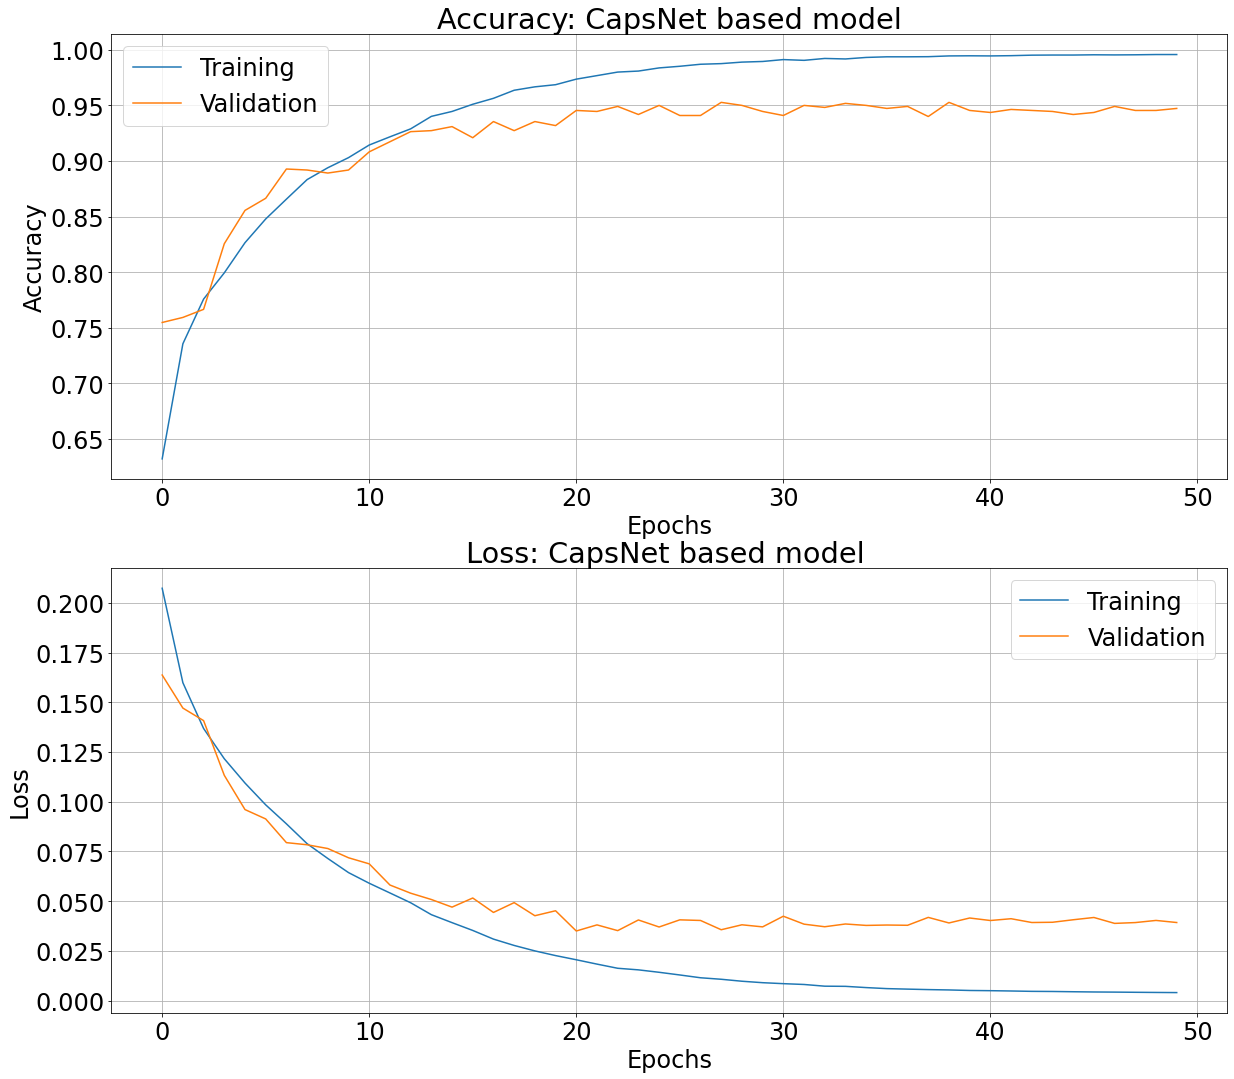

In [23]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 3))
fig, ax = plt.subplots(2, 1, figsize=(20,18))
ax = ax.ravel()
plt.rcParams.update({'font.size': 24})


# spanish

# titles = ['Precisión del modelo CapsNet', 'Pérdida del modelo CapsNet']
# ylabels = ['Precisión', 'Pérdida']
# epoch_Label = 'Épocas'
# legend_ = ['Entrenamiento', 'Validación']

# english
titles = ['Accuracy: CapsNet based model', 'Loss: CapsNet based model ']
ylabels = ['Accuracy', 'Loss']
epoch_Label = 'Epochs'
legend_ = ['Training', 'Validation']



font_size = 24

for i, met in enumerate(['capsnet_acc', 'capsnet_loss']):
    ax[i].plot(history[met])
    ax[i].plot(history['val_' + met])
    # ax[i].set_title('Model {}'.format(met))
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(epoch_Label, fontsize=font_size)
    # ax[i].set_ylabel(met)
    ax[i].set_ylabel(ylabels[i], fontsize=font_size)
    # ax[i].legend(['train', 'val'])
    ax[i].legend(legend_)
    ax[i].grid()



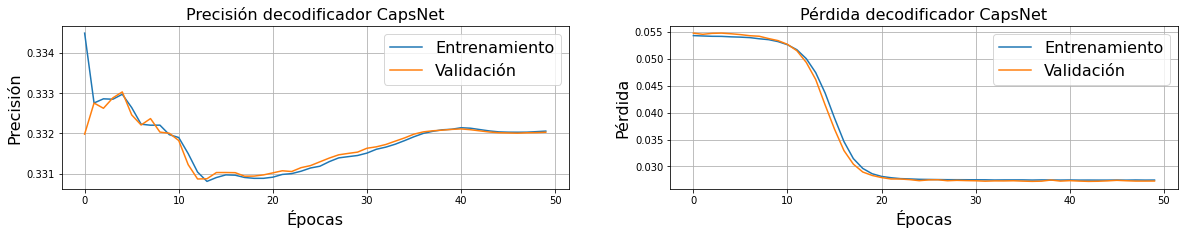

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

# for i, met in enumerate(['decoder_acc', 'decoder_loss']):
#     ax[i].plot(history[met])
#     ax[i].plot(history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])

titles = ['Precisión decodificador CapsNet', 'Pérdida decodificador CapsNet']
ylabels = ['Precisión', 'Pérdida']
font_size = 16

for i, met in enumerate(['decoder_acc', 'decoder_loss']):
    ax[i].plot(history[met])
    ax[i].plot(history['val_' + met])
    ax[i].set_title(titles[i], fontsize=font_size)
    ax[i].set_xlabel('Épocas', fontsize=font_size)
    ax[i].set_ylabel(ylabels[i], fontsize=font_size)
    ax[i].legend(['Entrenamiento', 'Validación'], fontsize=font_size)
    ax[i].grid()

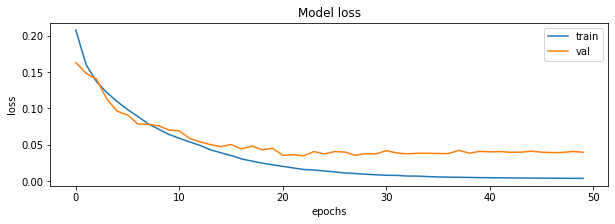

In [ ]:
plt.subplots(1, 1, figsize=(10, 3))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model {}'.format('loss'))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])

In [ ]:
x_train = None
x_valid = None
y_train = None
y_valid = None

x_test = None
y_test = None

In [23]:

test_data =  np.load('/content/drive/MyDrive/npzfiles/test.npz')
x_test = test_data['x_test']
y_test = test_data['y_test']


In [24]:
y_test.shape

(1102,)

In [31]:
train_model.load_weights("/content/drive/MyDrive/capsTraining/weights-28.h5")

In [32]:
ypred, xrecon = train_model.predict([x_test, to_categorical(y_test, 2)],  batch_size=100)
# yypred, xrecon = eval_model.predict(x_test, batch_size=100)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [33]:
print(ypred.shape)
print(y_test.shape)

(1102, 2)
(1102,)


In [34]:
 predictions = np.argmax(ypred, axis = 1)
 predictions

array([1, 0, 0, ..., 0, 0, 0])

In [35]:
cm = confusion_matrix(y_test, predictions)
cm

array([[630,  14],
       [ 36, 422]])

In [43]:
import itertools #create iterators for effective looping
plt.rcParams.update({'font.size': 12})

def plot_cm():
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  print('Transacciones legítimas detectadas (Verdaderos Negativos ): ', cm[0][0])
  print('Transacciones legítimas detectadas incorrectamente (Falsos Positivos): ', cm[0][1])
  print('Transacciones fraudulentas perdidas (Falsos Negativos): ', cm[1][0])
  print('Transacciones fraudulentas detectadas (Verdaderos Positivos): ', cm[1][1])
  print('Total de transacciones fraudulentas: ', np.sum(cm[1]))



def plot_confusion_matrix(cm, classes, cmap=plt.cm.Oranges):
                         
    
    # english labels
    title_ = 'CapsNet based model'
    ylabel_='True label'
    xlabel_= 'Predicted label'
    

    # spanish labels
    # title_ = 'Modelo basado en CapsNet'
    # ylabel_='Etiqueta vedadera'
    # xlabel_= 'Etiqueta predicha'

    print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title_)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel(ylabel_)
    plt.xlabel(xlabel_)
    plt.tight_layout()

def plot_roc():

      # english labels
  random_guess = 'Random guess'
  Perfect_performance = 'Perfect performance'
  fp_rate = 'False positive rate'
  tp_rate = 'True positive rate'
  title_roc = 'CapsNet based model'
  xlabel_ = 'ROC curve  (area = {:.2f} )'

  # spanish labels

  # random_guess = 'Suposición aleatoria'
  # Perfect_performance = 'Rendimiento perfecto'
  # fp_rate = 'Tasa de falsos positivos'
  # tp_rate = 'Tasa de verdaderos positivos'
  # title_roc = 'Modelo basado en CapsNet'
  # xlabel_ = 'Curva ROC  (área = {:.2f} )'


  font_size = 16
  fpr, tpr, thresholds = roc_curve(y_test, predictions)
  roc_auc = auc(fpr, tpr)
  # plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
  plt.plot(fpr, tpr, lw = 2, label = xlabel_.format(roc_auc))
  plt.plot([0, 1], [0, 1],
          linestyle = '--',
          color = (0.6, 0.6, 0.6),
          label = random_guess)
  plt.plot([0, 0, 1], [0, 1, 1],
          linestyle = ':',
          color = 'black', 
          label = Perfect_performance)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel(fp_rate)
  plt.ylabel(tp_rate)
  plt.title(title_roc)
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()  

Transacciones legítimas detectadas (Verdaderos Negativos ):  630
Transacciones legítimas detectadas incorrectamente (Falsos Positivos):  14
Transacciones fraudulentas perdidas (Falsos Negativos):  36
Transacciones fraudulentas detectadas (Verdaderos Positivos):  422
Total de transacciones fraudulentas:  458


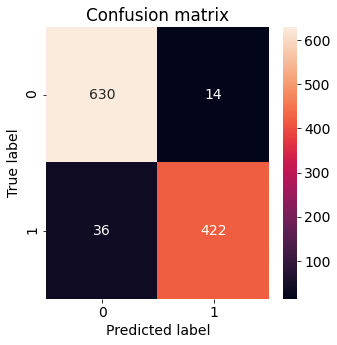

In [37]:
plot_cm()

In [ ]:
TN = cm[1][1]
print("TN: ", TN)
FP = cm[0][1]
print("FP: ", FP)
FN = cm[1][0]
print("FN: ", FN)
TP = cm[0][0]
print("TP: ", TP)
print("******************************************************")
Accuracy = (TP+TN) / (TP+TN+FP+FN)
print("Accuracy: ", Accuracy)
Sensitivity =  TP/(TP+FN)    
print("Sensitivity: ", Sensitivity)
Specificity = TN/(TN+FP)
print("Specificity: ", Specificity)

TN:  630
FP:  14
FN:  36
TP:  422
******************************************************
Accuracy:  0.9546279491833031
Sensitivity:  0.9213973799126638
Specificity:  0.9782608695652174


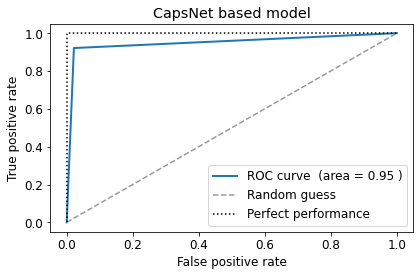

In [44]:
plot_roc()

[[630  14]
 [ 36 422]]


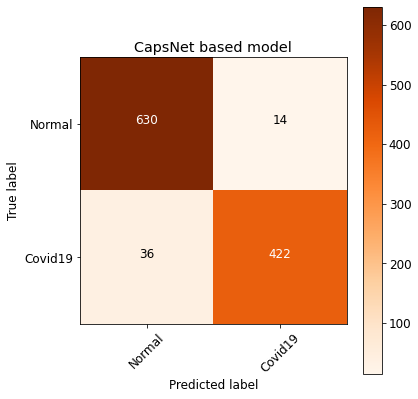

In [45]:
class_names=["Normal","Covid19"]
cm3 = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm3, classes=class_names)

In [ ]:
len(y_test)

1102

In [ ]:
class_normal = 0
class_covid = 0
for i in y_test:
  if i == 1:
    class_covid = class_covid + 1
  else:
    class_normal = class_normal + 1 

print('class_normal ', class_normal)     
print('class_covid ', class_covid)     

class_normal  644
class_covid  458


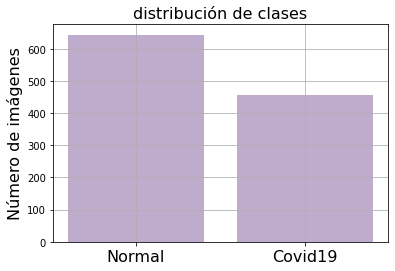

In [ ]:
fontsize=15
objects=["Normal","Covid19"]
y_pos = np.arange(len(objects))
count=[class_normal,class_covid]
plt.bar(y_pos, count, align='center', alpha=0.5, color=(0.5, 0.35, 0.6, 0.6))
plt.xticks(y_pos, objects, fontsize=font_size)
plt.ylabel('Número de imágenes', fontsize=font_size)
plt.title('distribución de clases', fontsize=font_size)
plt.grid(True)


# plt.savefig('./Images/Figure4.jpg')
# plt.show('./Images/Figure4.jpg')